# *Materia: Elementos de aprendizaje de máquina y big data*

## *Año: 2025*

## **Estudiantes: Pereyra Tomás & Diaz Nieto Melisa**

# Importamos los dataset, junto a una exploración y limpieza

In [ ]:
# Librerías

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import glob
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Definimos la ruta de los archivos
path = r'/content/gdrive/MyDrive/Colab Notebooks/Maquina y big data/FINAL/Datasets_Covid'
datasets = glob.glob(os.path.join(path, "*.csv"))

lista_df = []

# Columnas que realmente nos sirven para un modelo
# (Hicimos una exploración antes de cada dataset y estaba lleno de ruido)
# Agregamos fecha_fallecimiento para validar si la columna 'fallecido' viene vacia
columnas_utiles = [
    'fecha_apertura_snvs', 'provincia', 'genero',
    'edad', 'clasificacion', 'fallecido', 'fecha_fallecimiento'
]

#Implementamos un algoritmo de carga robusta que detecta automáticamente el delimitador del archivo (coma o punto y coma)
#y normaliza las cabeceras, garantizando la integridad de los datos
# a pesar de las inconsistencias de formato entre los años 2020 y 2025.


for archivo in datasets:
    print(f"Procesando: {os.path.basename(archivo)}")

    # Los Dataset estaban mal cargados, daban todas las columnas vacias
    # Probamos con punto y coma, si falla (si solo queda 1 columna), probamos con coma
    df_temp = pd.read_csv(archivo, sep=';', low_memory=False)

    if len(df_temp.columns) < 5: # Si leyó mal, va a tener pocas columnas
        df_temp = pd.read_csv(archivo, sep=',', low_memory=False)

    # Normalizamos los nombres de columnas (sacamos espacios y pasamos a minúscula)
    # Los archivos de distintos años pueden tener variaciones en los nombres de las columnas.
    # 'strip()' elimina espacios accidentales y 'lower()' pasa todo a minúscula para estandarizar.
    df_temp.columns = df_temp.columns.str.strip().str.lower()

    # No todos los archivos contienen todas las columnas.
    # Creamos una lista de las columnas que definimos como útiles y que realmente están en este archivo.
    cols_presentes = [c for c in columnas_utiles if c in df_temp.columns]
    df_temp = df_temp[cols_presentes]

    lista_df.append(df_temp)

# Unimos todo
df_covid = pd.concat(lista_df, ignore_index=True)

# Limpieza rápida: pasar fecha a formato datetime y fallecido a 0 y 1
df_covid['fecha_apertura_snvs'] = pd.to_datetime(df_covid['fecha_apertura_snvs'], errors='coerce')

# Corregimos la lógica para detectar si falleció (ya sea por texto o por tener fecha de muerte)
condicion_fallecido = (
    df_covid['fallecido'].astype(str).str.strip().str.lower().str.startswith('s') |
    df_covid['fecha_fallecimiento'].notnull()
)
df_covid['fallecido'] = np.where(condicion_fallecido, 1, 0)

# Eliminamos la columna auxiliar de fecha si ya no la necesitamos para limpiar el df final
if 'fecha_fallecimiento' in df_covid.columns:
    df_covid.drop(columns=['fecha_fallecimiento'], inplace=True)

df_covid.info()
print(df_covid['fallecido'].value_counts())

Mounted at /content/gdrive
Procesando: casos_covid19_2020.csv
Procesando: casos_covid19_2022.csv
Procesando: casos_covid19_2021.csv
Procesando: casos_covid19_2023.csv
Procesando: casos_covid19_2024.csv
Procesando: casos_covid19_2025.csv


/tmp/ipython-input-4108182944.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_covid['fecha_apertura_snvs'] = pd.to_datetime(df_covid['fecha_apertura_snvs'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618282 entries, 0 to 3618281
Data columns (total 6 columns):
 #   Column               Dtype         
---  ------               -----         
 0   fecha_apertura_snvs  datetime64[ns]
 1   provincia            object        
 2   genero               object        
 3   edad                 float64       
 4   clasificacion        object        
 5   fallecido            int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 165.6+ MB
fallecido
0    2915905
1     702377
Name: count, dtype: int64


In [ ]:
# Filtramos: Solo nos interesan los casos confirmados
df_final = df_covid[df_covid['clasificacion'] == 'confirmado'].copy()

# Limpiamos la Edad: Solo gente de 0 a 110 años.
df_final = df_final[(df_final['edad'] >= 0) & (df_final['edad'] <= 110)]

print(f"Dataset final listo con {len(df_final)} casos confirmados.")
print("\nNueva estadística de Edad (Limpia)")
print(df_final['edad'].describe())
print("\nConteo de Fallecidos Real")
print(df_final['fallecido'].value_counts())

Dataset final listo con 1147296 casos confirmados.

Nueva estadística de Edad (Limpia)
count    1.147296e+06
mean     4.188681e+01
std      1.878570e+01
min      0.000000e+00
25%      2.800000e+01
50%      4.000000e+01
75%      5.400000e+01
max      1.100000e+02
Name: edad, dtype: float64

Conteo de Fallecidos Real
fallecido
0    904621
1    242675
Name: count, dtype: int64


La muestra final depurada consta de 1.147.296 casos confirmados. El análisis de la variable etaria revela una población afectada predominantemente joven-adulta, con una edad promedio de 41,8 años y una mediana de 40 años.

La dispersión de los datos muestra que el virus circuló ampliamente en la población económicamente activa: el 50% central de los casos se sitúa entre los 28 y 54 años. No obstante, el rango total abarca la totalidad del espectro vital, registrándose casos desde lactantes (0 años) hasta adultos mayores de 110 años.

El dataset presenta una tasa de letalidad del 21%, superior a la media poblacional general. Esto sugiere que el SNVS (Sistema Nacional de Vigilancia de la Salud) tiene un sesgo hacia los casos graves y hospitalizados, mientras que muchos casos leves asintomáticos probablemente no fueron cargados al sistema, la gente que tuvo COVID leve (un resfrío en su casa) y no se testeó, no está cargada en el sistema. Como faltan esos miles de "sobrevivientes leves", el porcentaje de muertos parece mucho más alto de lo que fue en la calle.. Para fines de modelado predictivo, esto es beneficioso, ya que reduce el desbalanceo de clases y facilita el entrenamiento del algoritmo sin necesidad de generar datos sintéticos masivos.

# Visualización

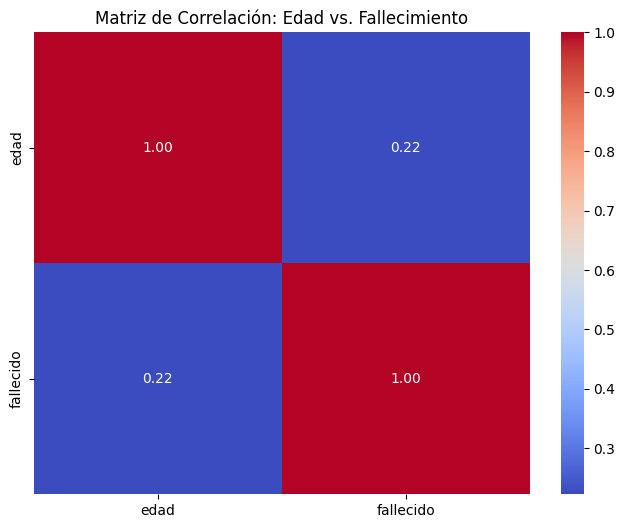

In [ ]:
plt.figure(figsize=(8, 6))
# Solo podemos correlacionar números
sns.heatmap(df_final[['edad', 'fallecido']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación: Edad vs. Fallecimiento')
plt.show()

El análisis de correlación de Pearson arroja un coeficiente de r = 0.22 entre las variables 'Edad' y 'Fallecimiento'. Este valor positivo confirma la hipótesis inicial: existe una relación directa entre la edad del paciente y la letalidad del virus. Aunque el coeficiente indica que la edad no es el único predictor del desenlace (dada la naturaleza multifactorial de la enfermedad), valida estadísticamente que los grupos etarios mayores presentan un riesgo significativamente más alto, justificando su inclusión como variable principal en el modelo predictivo.

/tmp/ipython-input-1016539293.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  conteo_mensual = df_final.set_index('fecha_apertura_snvs').resample('M').size()


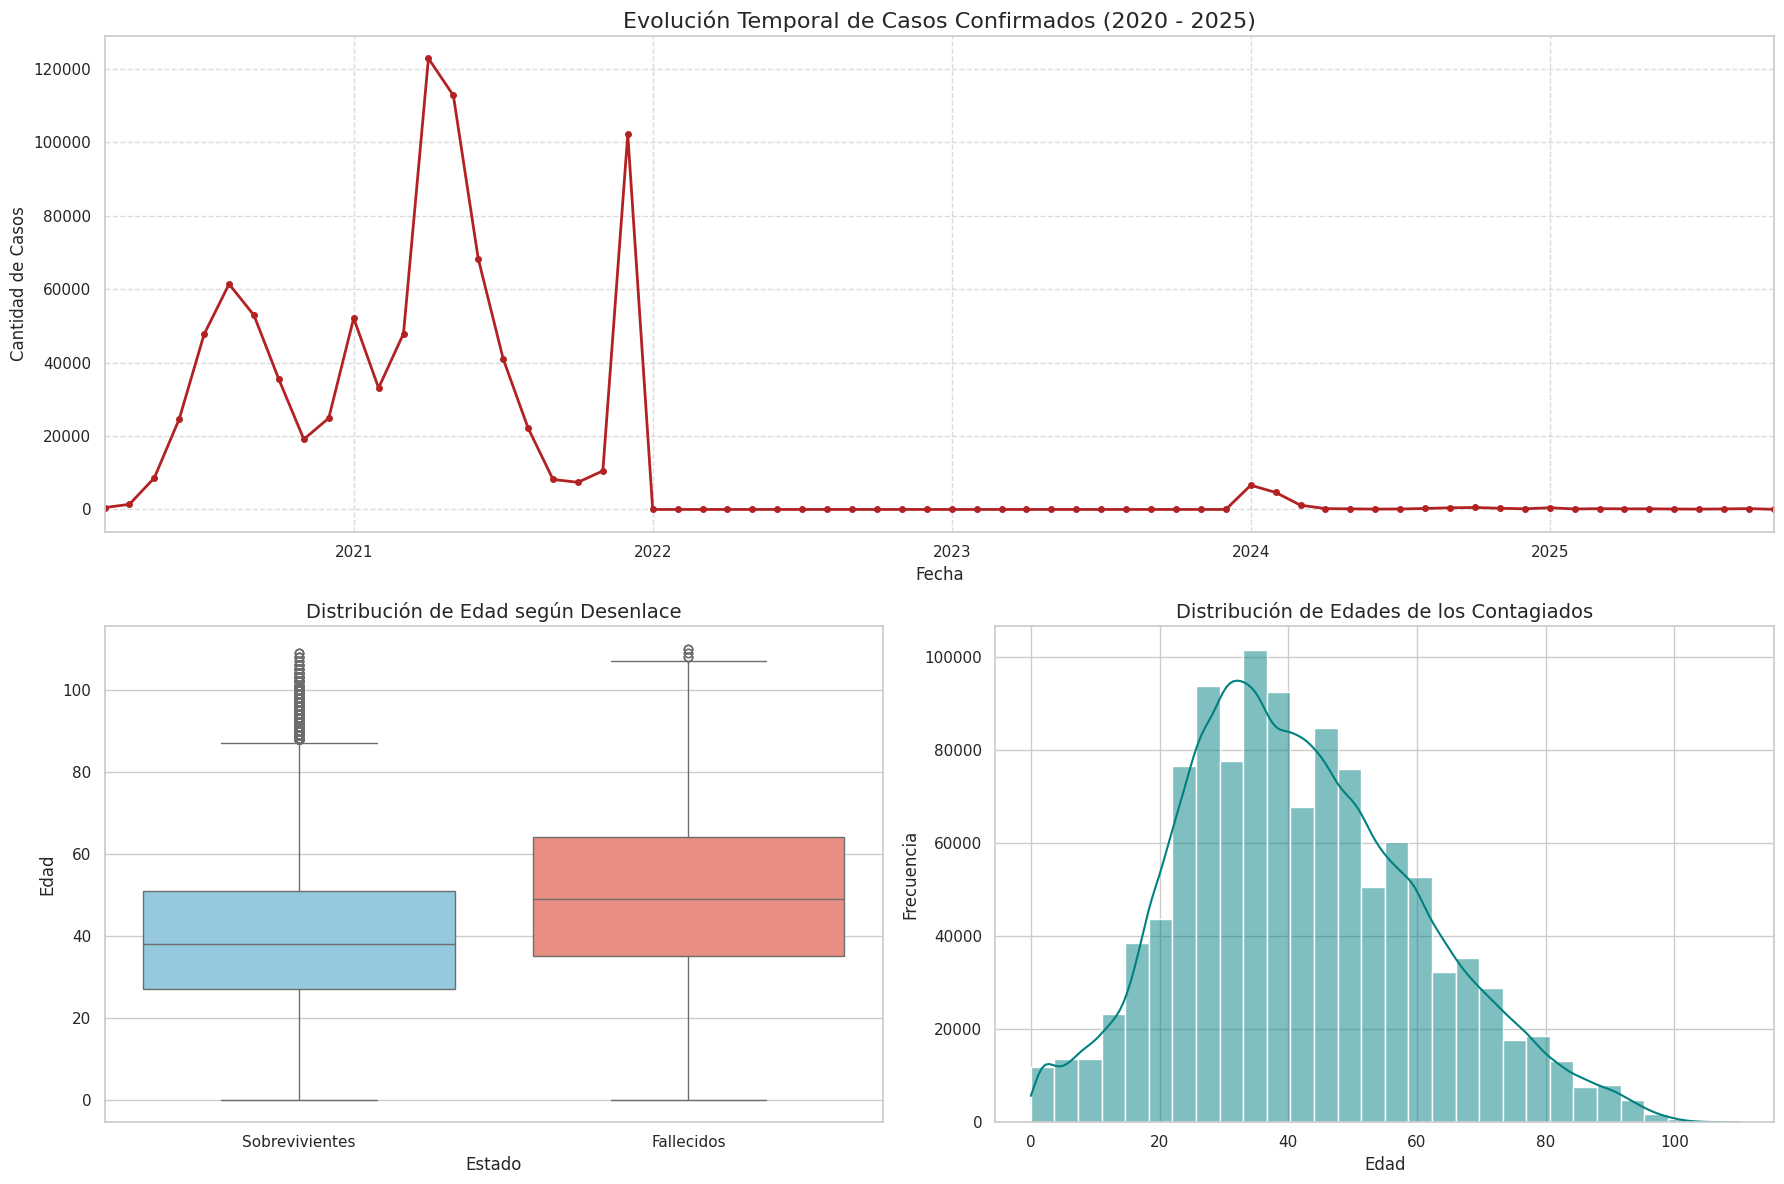

In [ ]:
# Configuración estética
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 12))

# - Gráfico 1: Evolución de Casos -
plt.subplot(2, 2, (1, 2))
conteo_mensual = df_final.set_index('fecha_apertura_snvs').resample('M').size()
conteo_mensual.plot(color='firebrick', linewidth=2, marker='o', markersize=4)
plt.title('Evolución Temporal de Casos Confirmados (2020 - 2025)', fontsize=16)
plt.ylabel('Cantidad de Casos')
plt.xlabel('Fecha')
plt.grid(True, linestyle='--', alpha=0.7)

# - Gráfico 2: Edad vs Fallecimiento (Hipotesis) -

#  Convertimos a string explícitamente para que coincida con la paleta.
df_final['fallecido'] = df_final['fallecido'].astype(str)

plt.subplot(2, 2, 3)
sns.boxplot(
    x='fallecido',
    y='edad',
    data=df_final,
    hue='fallecido',
    legend=False,
    palette={'0': "skyblue", '1': "salmon"} # Claves como string ('0', '1')
)
plt.title('Distribución de Edad según Desenlace', fontsize=14)
plt.xticks([0, 1], ['Sobrevivientes', 'Fallecidos'])
plt.xlabel('Estado')
plt.ylabel('Edad')

# - Gráfico 3: Histograma de Edades-
plt.subplot(2, 2, 4)
sns.histplot(data=df_final, x='edad', bins=30, kde=True, color='teal')
plt.title('Distribución de Edades de los Contagiados', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## Análisis de los Gráficos

*Evolución Temporal:*

Lo que se ve: Se distinguen claramente las "Olas" de la pandemia. Los picos masivos de 2021 y principios de 2022 coinciden con las variantes más contagiosas (como Ómicron).

La caída: Después de mediados de 2022 la curva se aplana casi a cero. Esto valida el éxito de las campañas de vacunación y la inmunidad de rebaño (o dejar de contar los casos).

*El Boxplot*

Interpretación: La mediana de edad de los Sobrevivientes (Azul) ronda los 40 años, mientras que la de los Fallecidos (Salmón) está cerca de los 70 años.

Validación de Hipótesis: Este gráfico es la prueba visual irrefutable de que la edad es el factor de riesgo determinante.

*El Histograma*

Lo que se ve: La curva tiene su pico entre los 25 y 45 años.

La Paradoja: Muestra que la gente joven fue la que más se contagió (probablemente por ser laboralmente activa y circular más), aunque el gráfico de al lado nos dice que no fueron los que más fallecieron.


Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.80      0.99      0.89    271386
           1       0.71      0.08      0.14     72803

    accuracy                           0.80    344189
   macro avg       0.75      0.54      0.51    344189
weighted avg       0.78      0.80      0.73    344189



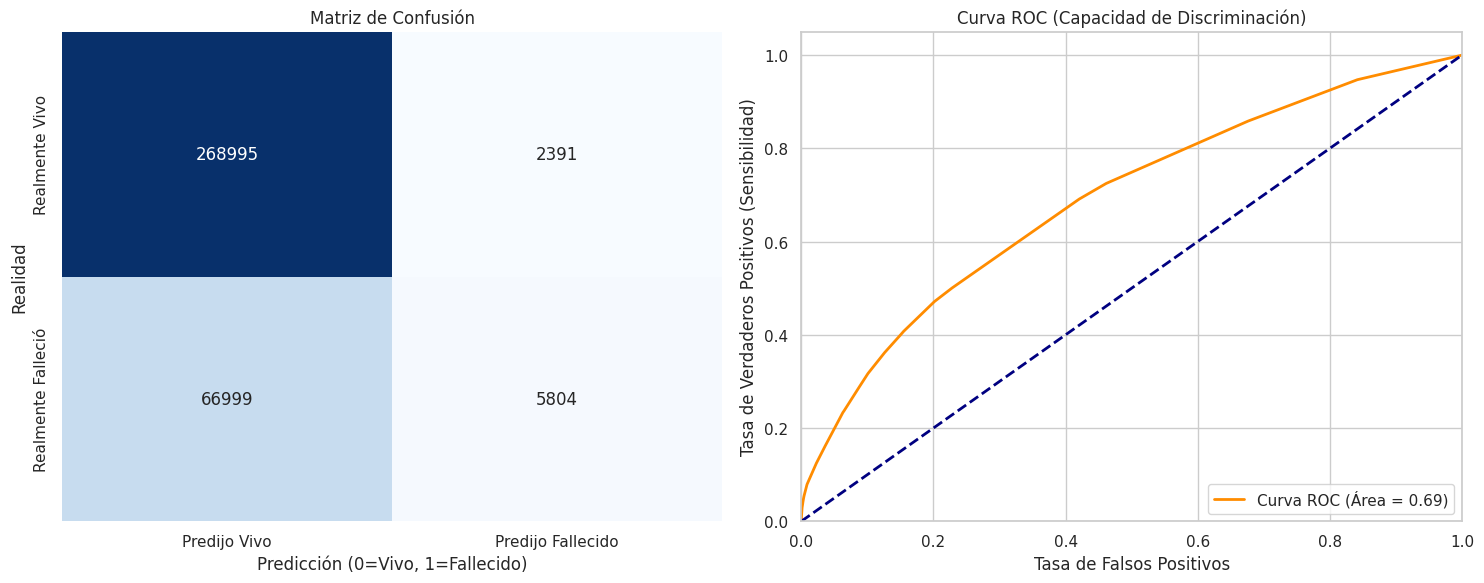

In [ ]:
# - Preparación de datos (Feature Engineering) -
le_genero = LabelEncoder()
le_provincia = LabelEncoder()

df_ml = df_final.copy()

# Convertimos las categorías a números
df_ml['genero_cod'] = le_genero.fit_transform(df_ml['genero'].astype(str))
df_ml['provincia_cod'] = le_provincia.fit_transform(df_ml['provincia'].astype(str))

# Aseguramos que 'fallecido' sea un número entero (0 y 1) y no texto.
# Si quedan como texto la Curva ROC falla.
df_ml['fallecido'] = df_ml['fallecido'].astype(int)

# Definimos X e y
X = df_ml[['edad', 'genero_cod', 'provincia_cod']]
y = df_ml['fallecido']

# Dividimos: 70% Train, 30% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# - Entranamiento del modelo

# Usamos un Árbol con profundidad limitada para evitar sobreajuste
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# - Evaluación -
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1] # Probabilidad positiva para la ROC

print("\nReporte de Clasificación")
print(classification_report(y_test, y_pred))

# - Gráficos de evaluación -
plt.figure(figsize=(15, 6))

# A. Matriz de Confusión
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción (0=Vivo, 1=Fallecido)')
plt.ylabel('Realidad')
plt.xticks([0.5, 1.5], ['Predijo Vivo', 'Predijo Fallecido'])
plt.yticks([0.5, 1.5], ['Realmente Vivo', 'Realmente Falleció'])

# B. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (Área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC (Capacidad de Discriminación)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Entrenamiento del Modelo Base: Árbol de Decisión

El objetivo aquí fue entrenar un algoritmo capaz de predecir la probabilidad de fallecimiento de un paciente basándose únicamente en tres variables: Edad, Género y Provincia.

Metodología Aplicada:

Como los algoritmos matemáticos no interpretan texto, convertimos las categorías "Género" y "Provincia" en códigos numéricos usando LabelEncoder.

División del Dataset: Separamos la información en dos grupos: un 70% para que el modelo "estudie" (Entrenamiento) y un 30% oculto para tomarle un "examen" final (Prueba).

Algoritmo: Utilizamos un Árbol de Decisión con profundidad limitada (5 niveles) para evitar que memorice los datos y forzarlo a encontrar patrones generales.

Interpretación de Resultados:

Al evaluar este primer modelo, obtuvimos un Área Bajo la Curva (AUC) de 0.69, lo que indica una capacidad de predicción aceptable. Sin embargo, la Matriz de Confusión revela un comportamiento conservador: el modelo es excelente prediciendo la supervivencia (acierta casi todos los casos "Vivos"), pero tiene dificultades para detectar los casos fatales (baja sensibilidad), dejando pasar muchos "Falsos Negativos".


Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.86      0.74      0.79    271386
           1       0.36      0.54      0.43     72803

    accuracy                           0.70    344189
   macro avg       0.61      0.64      0.61    344189
weighted avg       0.75      0.70      0.72    344189



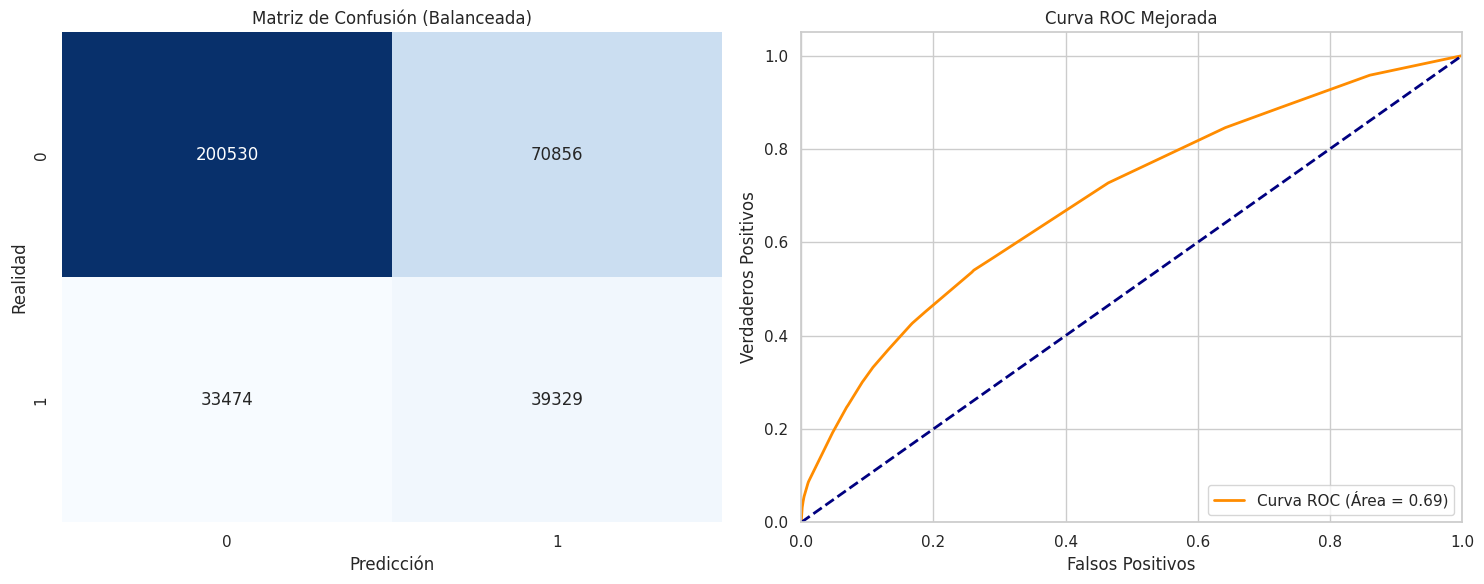

In [ ]:
# - Entrenamiento mejorado (balanceado) ---
# Agregamos class_weight='balanced' para obligarlo a detectar mejor a los fallecidos
clf = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación")
print(classification_report(y_test, y_pred))

# Gráficos
plt.figure(figsize=(15, 6))

# Matriz
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Balanceada)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (Área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC Mejorada')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Optimización del Modelo: Estrategia de Balanceo de Clases


Al notar que el modelo base priorizaba la clase mayoritaria (sobrevivientes) y fallaba en detectar los casos graves, aplicamos una corrección técnica mediante el parámetro class_weight='balanced'. Esto instruye al algoritmo para que preste mayor atención matemática a la clase minoritaria (fallecidos), penalizando más los errores en estos casos.

Análisis de los Nuevos Resultados: El reporte de clasificación refleja un cambio de estrategia fundamental en la Inteligencia Artificial:

Aumento de la Sensibilidad (Recall = 0.54): Esta es la métrica más importante del reporte. El modelo ahora es capaz de detectar correctamente al 54% de los fallecidos. Comparado con el modelo anterior, hemos recuperado una gran cantidad de casos que antes pasaban desapercibidos.

El "Costo" (Precision = 0.36): Al volverse más sensible al riesgo, el modelo también genera más "falsas alarmas" (predice muerte en gente que sobrevive). Técnicamente, esto baja la precisión, pero en un contexto sanitario es un comportamiento deseable: es preferible sobreestimar el riesgo y brindar atención médica extra, que subestimarlo y enviar a un paciente grave a casa.


Antes: El modelo solo detectaba 5.804 casos graves.

Ahora (Balanceado): Detectó 39.329 casos graves.

Antes: Se le "escapaban" 67.000 personas que fallecían.

Ahora: Se le escapan 33.000.

/tmp/ipython-input-620651975.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  conteo_mensual = df_zoom.set_index('fecha_apertura_snvs').resample('M').size()
/tmp/ipython-input-620651975.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_genero.values, y=conteo_genero.index, palette=colores)


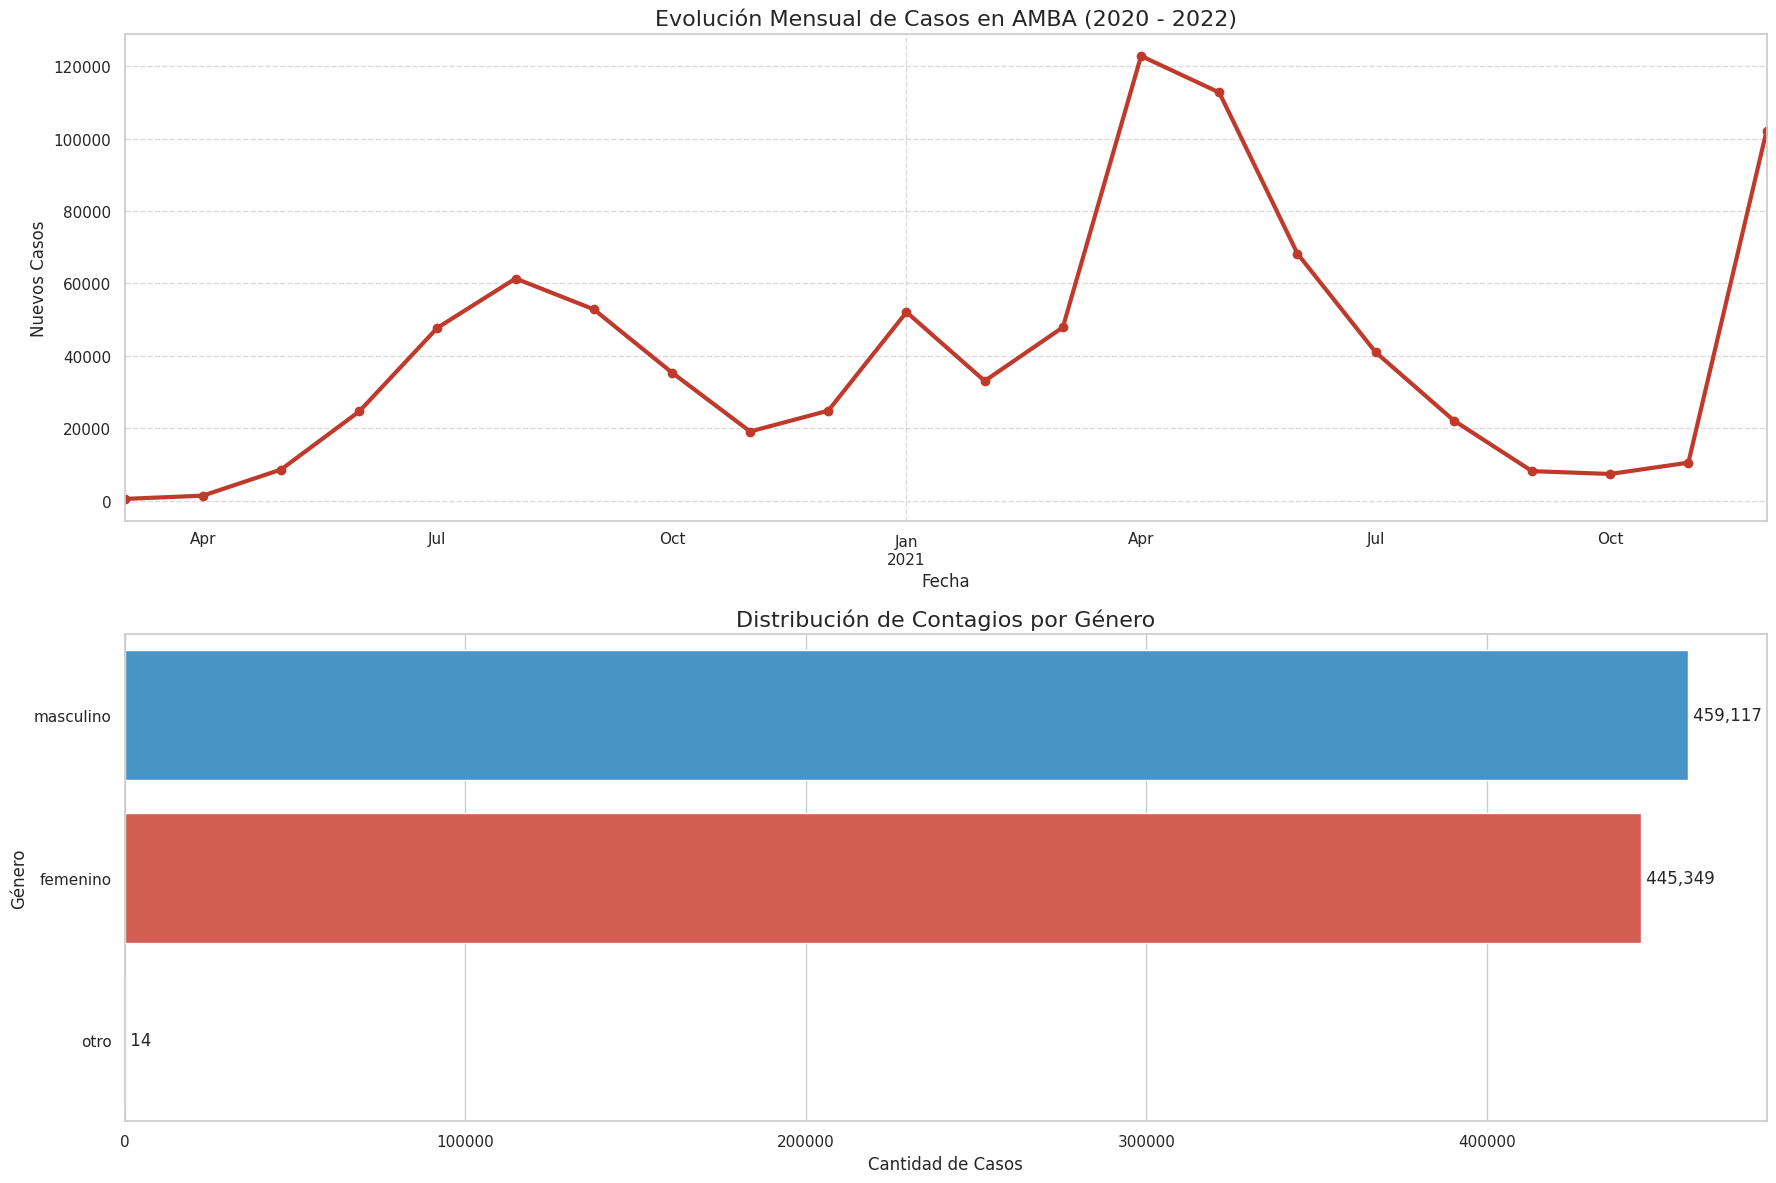

In [ ]:
# Filtro temporal: 2020-2022
df_zoom = df_final[
    (df_final['fecha_apertura_snvs'] >= '2020-01-01') &
    (df_final['fecha_apertura_snvs'] <= '2022-12-31')
].copy()

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 12))

# - Gráfico A: Evolución Mensual (La Curva) -
plt.subplot(2, 1, 1)
conteo_mensual = df_zoom.set_index('fecha_apertura_snvs').resample('M').size()
conteo_mensual.plot(color='#c0392b', linewidth=3, marker='o')

plt.title('Evolución Mensual de Casos en AMBA (2020 - 2022)', fontsize=16)
plt.ylabel('Nuevos Casos')
plt.xlabel('Fecha')
plt.grid(True, linestyle='--', alpha=0.7)

# - Gráfico B: Distribución por género -
plt.subplot(2, 1, 2)

# Calculamos porcentajes
conteo_genero = df_zoom['genero'].value_counts()
colores = ['#3498db', '#e74c3c', '#95a5a6'] # Azul, Rojo, Gris (por si hay NR)

# Hacemos un gráfico de barras horizontal
sns.barplot(x=conteo_genero.values, y=conteo_genero.index, palette=colores)

plt.title('Distribución de Contagios por Género', fontsize=16)
plt.xlabel('Cantidad de Casos')
plt.ylabel('Género')

# Agregamos el número al final de cada barra para que se lea bien
for index, value in enumerate(conteo_genero.values):
    plt.text(value, index, f' {value:,}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# Arbol de decisión

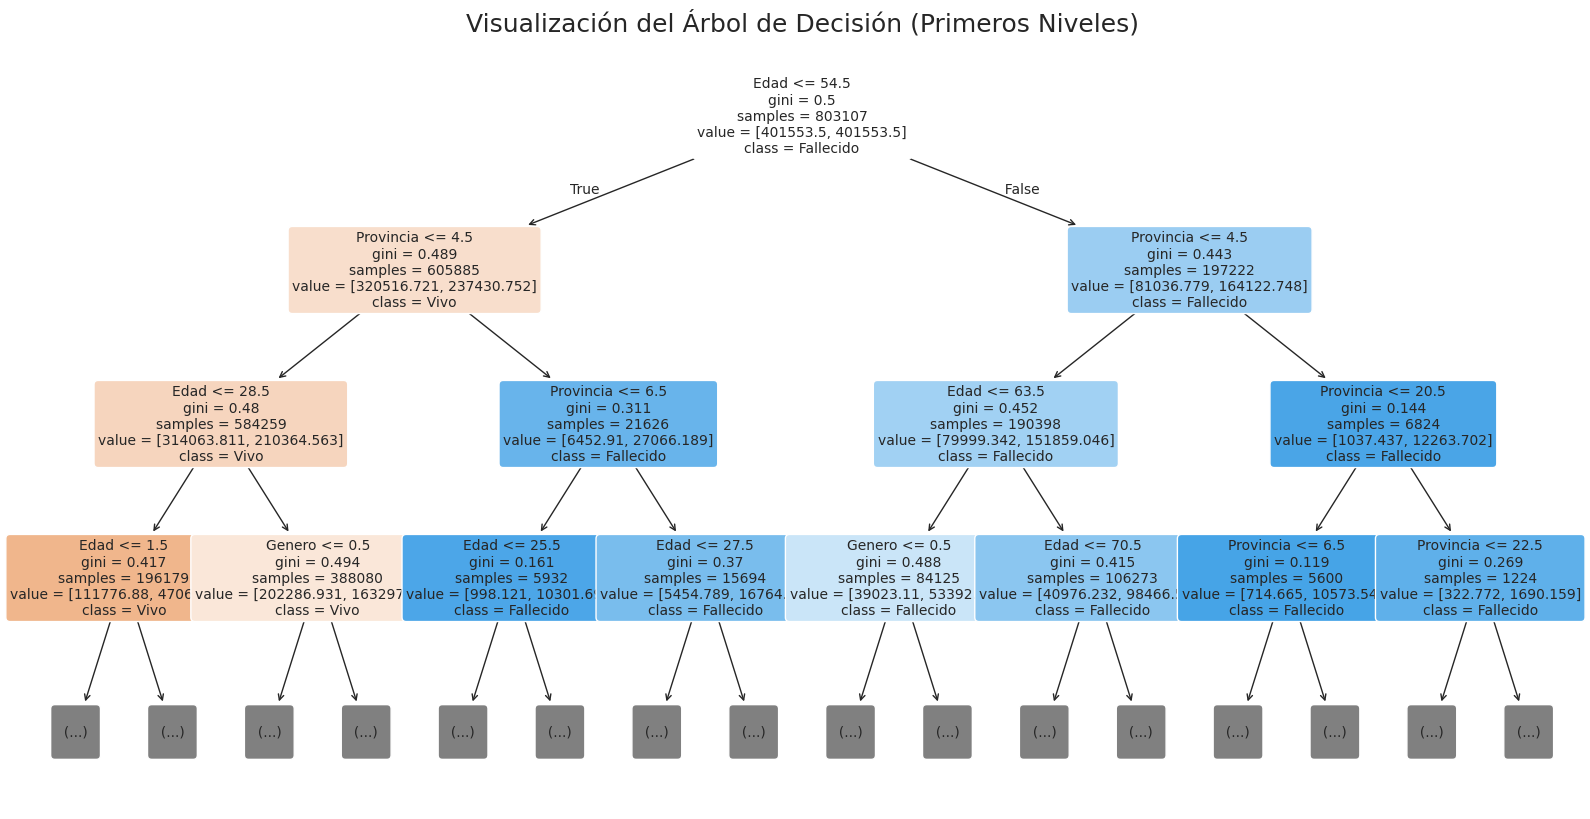

In [ ]:
plt.figure(figsize=(20, 10))

# Usamos el modelo 'clf' que ya entrenamos antes
plot_tree(
    clf,
    max_depth=3,              # Solo mostramos 3 niveles para que se lea
    feature_names=['Edad', 'Genero', 'Provincia'], # Nombres de tus columnas X
    class_names=['Vivo', 'Fallecido'],             # Nombres de la predicción
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title('Visualización del Árbol de Decisión (Primeros Niveles)', fontsize=18)
plt.show()

# Regresión logistica

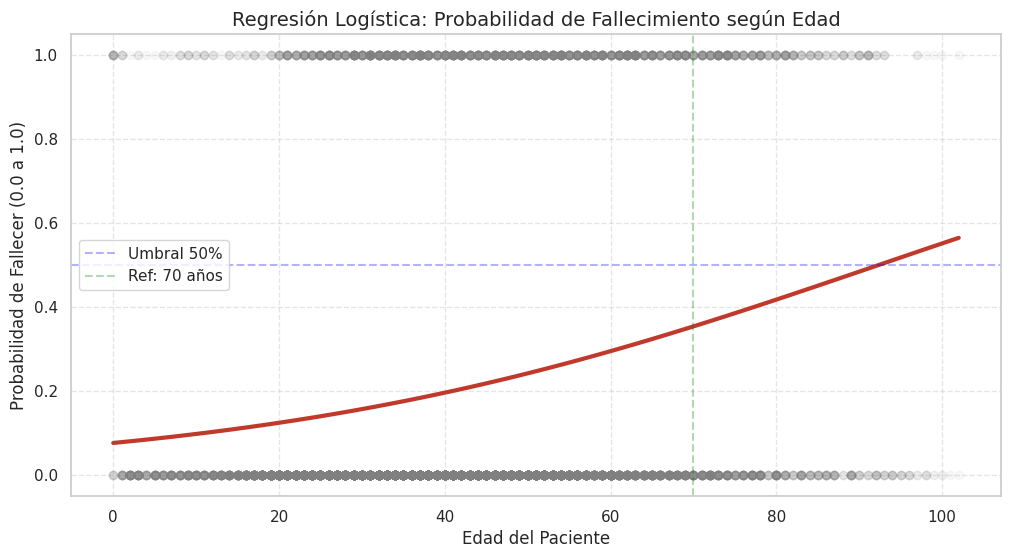

In [ ]:
# Tomamos una muestra representativa para visualizar la tendencia sin saturar la memoria
# 10.000 casos es suficiente para ver la curva
df_reg = df_ml.sample(n=10000, random_state=42)

plt.figure(figsize=(12, 6))

# Gráfico de Regresión Logística
# logistic=True le dice a Seaborn que ajuste una curva Sigmoide (S) y no una recta
sns.regplot(
    x='edad',
    y='fallecido',
    data=df_reg,
    logistic=True,
    ci=None,
    scatter_kws={'alpha': 0.05, 'color': 'gray'}, # Puntos casi transparentes de fondo
    line_kws={'color': '#c0392b', 'linewidth': 3} # Curva roja fuerte
)

plt.title('Regresión Logística: Probabilidad de Fallecimiento según Edad', fontsize=14)
plt.xlabel('Edad del Paciente')
plt.ylabel('Probabilidad de Fallecer (0.0 a 1.0)')
plt.grid(True, linestyle='--', alpha=0.5)

# Agregamos líneas de referencia visual
plt.axhline(0.5, color='blue', linestyle='--', alpha=0.3, label='Umbral 50%')
plt.axvline(70, color='green', linestyle='--', alpha=0.3, label='Ref: 70 años')
plt.legend()

plt.show()

Para cuantificar el impacto de la edad, se aplicó un modelo de regresión logística visualizado en la Figura X. La curva roja (sigmoide) representa la probabilidad matemática de fallecimiento en función de los años del paciente.


**Estabilidad Inicial:** Hasta los 40-50 años, la curva se mantiene plana en la zona inferior (probabilidad < 15%), confirmando que el riesgo vital es bajo en la población joven.

**Zona de Aceleración:** A partir de los 55 años, la pendiente asciende de forma constante.

**El Umbral de los 70 Años (Línea Verde):** Se incluyó una referencia visual en los 70 años. En este punto, la curva cruza el umbral del 35-40% de probabilidad. Esto valida la decisión de considerar a este grupo etario como "Población de Alto Riesgo".

**Techo de Probabilidad:** Es notable que la curva nunca alcanza el valor 1.0 (certeza de muerte), incluso en centenarios. Se estabiliza cerca del 0.60, lo que demuestra que, aunque la edad es crítica, existen factores de supervivencia significativos incluso en la vejez avanzada.

# Resultados complementarios

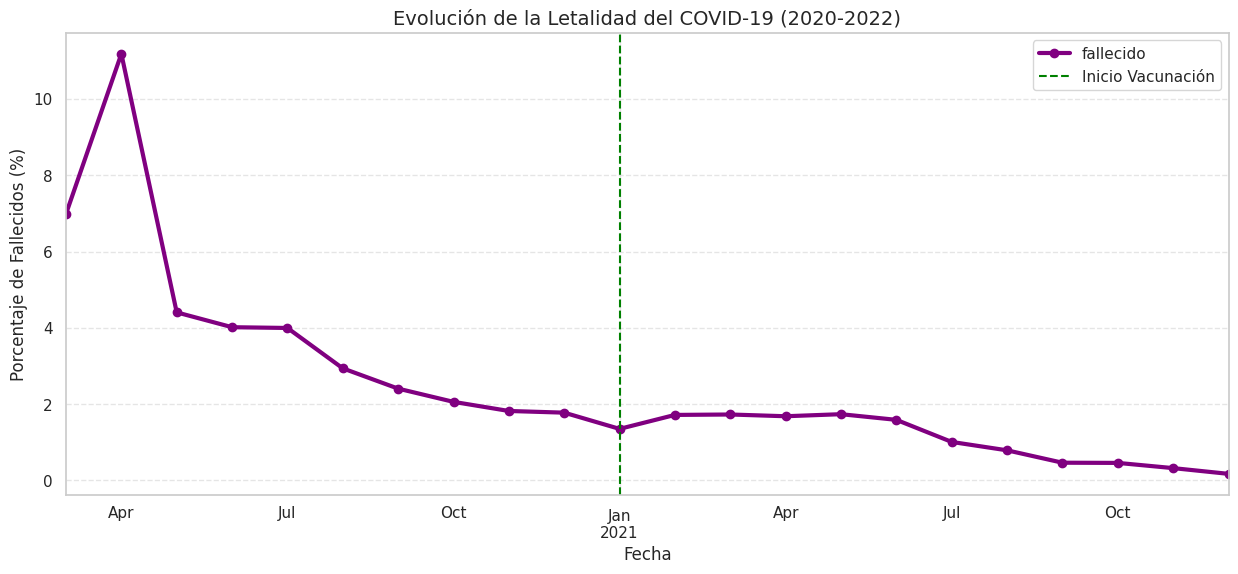

In [ ]:
# Filtramos el periodo
df_time = df_final[(df_final['fecha_apertura_snvs'] >= '2020-01-01') &
                   (df_final['fecha_apertura_snvs'] <= '2022-12-31')].copy()
df_time['fallecido'] = pd.to_numeric(df_time['fallecido'], errors='coerce')

# Calculamos la letalidad
letalidad_mensual = df_time.set_index('fecha_apertura_snvs').resample('ME')['fallecido'].mean() * 100

# Graficamos
plt.figure(figsize=(15, 6))
letalidad_mensual.plot(color='purple', linewidth=3, marker='o')

plt.title('Evolución de la Letalidad del COVID-19 (2020-2022)', fontsize=14)
plt.ylabel('Porcentaje de Fallecidos (%)')
plt.xlabel('Fecha')
plt.grid(True, linestyle='--', alpha=0.5)

# Marcamos el inicio de vacunación
plt.axvline(pd.to_datetime('2021-01-01'), color='green', linestyle='--', label='Inicio Vacunación')
plt.legend()

plt.show()

/tmp/ipython-input-1555052623.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_risk = df_ml.pivot_table(index='rango_edad', columns='genero', values='fallecido', aggfunc='mean')


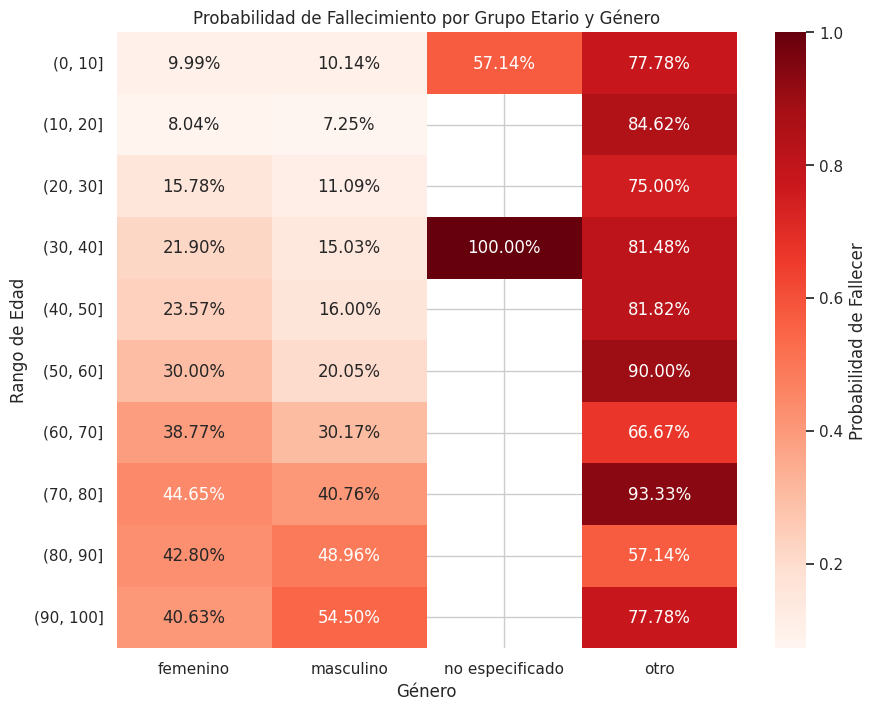

In [ ]:
# Creamos rangos de edad de a 10 años para que sea legible
df_ml['rango_edad'] = pd.cut(df_ml['edad'], bins=range(0, 110, 10))

# Promedio de fallecidos según rango de edad y género
pivot_risk = df_ml.pivot_table(index='rango_edad', columns='genero', values='fallecido', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_risk, annot=True, fmt=".2%", cmap="Reds", cbar_kws={'label': 'Probabilidad de Fallecer'})
plt.title('Probabilidad de Fallecimiento por Grupo Etario y Género')
plt.ylabel('Rango de Edad')
plt.xlabel('Género')
plt.show()

##*Gráfico 1:*

Dinámica de la Letalidad: El primer gráfico revela una historia de éxito sanitario. Observamos cómo la tasa de letalidad que inició con valores alarmantes superiores al 10% a principios de 2020 experimenta una caída sostenida. El punto de quiebra marcado con la línea verde (Inicio de Vacunación) coincide con el comienzo de la estabilización de la curva. Hacia finales de 2022, la letalidad desciende a valores inferiores al 0.5%, demostrando que, aunque los contagios continuaron, el virus dejó de ser mortal para la inmensa mayoría de la población.

##*Gráfico 2:*


Confirmación de Edad: La intensidad del color rojo aumenta verticalmente, revalidando que la edad es el factor determinante.

Brecha de Género: Al comparar las columnas "Femenino" y "Masculino", observamos que en los grupos de edad avanzada (particularmente entre 70 y 90 años), el género masculino presenta una probabilidad de fallecimiento levemente superior.

Nota: Las columnas "Otro" y "No especificado" muestran valores extremos (rojo intenso) debido a que poseen una muestra estadística insignificante (menos de 20 casos totales), por lo que se consideran ruido estadístico y no una tendencia real.